# Assigment 1

Created by Bas Chatel (<small>10246215</small>) and Lennart Mettrop (<small>1043973</small>)

## Initialise

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numba import jit
import random
from mpl_toolkits import mplot3d

# Initialise in notebook plotting
%matplotlib notebook


# Function for enhancing appearances of plotting
def plotpretify(ax, maxx, minx=0):
    # Remove borders    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    # Remove ticks    
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)
    
    # Create inner grid    
    ax.grid(True)

    # Focus image in right position    
    ax.set_xlim(minx, maxx)

## Definition and plotting of Mandelbrot set

In [2]:
# Implementing the Mandelbrot algorithm
@jit
def mandelbrot(z, maxiter, horizon, log_horizon):
    c = z

    # Iterate through max given iterations to check whether or not
    # the value is diverging or not
    for n in range(maxiter):
        az = abs(z)
        if az > horizon:
            return n - np.log(np.log(az)) / np.log(2) + log_horizon
        z = z * z + c
    return 0


# Create data within given bounds of the Mandelbrot set
@jit
def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, maxiter):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            n3[i, j] = mandelbrot(r1[i] + 1j * r2[j], maxiter, horizon,
                                  log_horizon)
    return (r1, r2, n3)


# Plot Mandelbrot image
@jit
def mandelbrot_plot(xmin,xmax,ymin,ymax,width=10,height=10,\
                     maxiter=80,cmap='jet',gamma=0.3):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x, y, z = mandelbrot_set(xmin, xmax, ymin, ymax, img_width, img_height,
                             maxiter)

    fig, ax = plt.subplots(figsize=(width, height), dpi=72)
    ticks = np.arange(0, img_width, 3 * dpi)
    x_ticks = xmin + (xmax - xmin) * ticks / img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax - ymin) * ticks / img_width
    plt.yticks(ticks, y_ticks)

    norm = colors.PowerNorm(gamma)
    ax.imshow(z.T, cmap=cmap, origin='lower', norm=norm)

### Plots

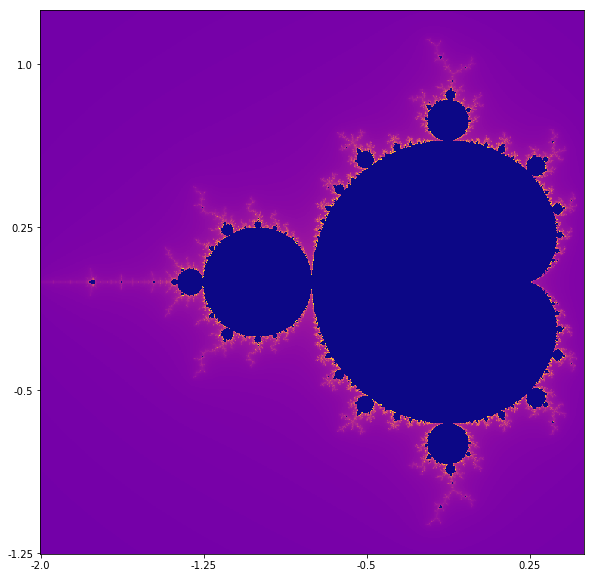

In [3]:
mandelbrot_plot(-2.0, 0.5, -1.25, 1.25, cmap='plasma', maxiter=800)

In [ ]:
mandelbrot_plot(-0.75, -0.747, 0.063, 0.06, cmap='bone', maxiter=8000)

In [ ]:
mandelbrot_plot(-0.749,-0.748,0.065,0.066,cmap='ocean',maxiter=2048)

## Pure Random Sampling

In [ ]:
# Best know estimate according to:
# mrob.com/pub/muency/areaofthemandelbrotset.html
@jit
def real():
    return 1.506591856 + 2.54 * (10**-8)


# Check whether or not a coordinate is in the Mandelbrot set
@jit
def checkInMS(z, maxiter, horizon, log_horizon):
    #     print(z)
    if mandelbrot(z, maxiter, horizon, log_horizon) == 0:
        return 1.0
    return 0.0


# Pure Random Sampling Monte Carlo integration
@jit
def MonteCarlo(s, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    for j in range(s):
        x = xmin + (xmax - xmin) * random.random()
        y = ymin + (ymax - ymin) * random.random()
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return (ctr / s) * area

In [ ]:
# Test the Pure Random Monte Carlo integration
result = MonteCarlo(77**2, 8000, -2.0, 0.5, -1.25, 1.25)
print("Approximated with Random Monte Carlo: {}".format(result))
print("Real value: {}".format(real()))
print("Difference: {}".format(result - real()))

## Latin cube

In [ ]:
def lhs(n):
    lower_lim = np.arange(0, n) / n
    upper_lim = np.arange(1, n + 1) / n

    points = np.random.uniform(low=lower_lim, high=upper_lim, size=[2, n]).T
    np.random.shuffle(points[:, 1])

    return points


@jit
def MonteCarloLatin(s, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    points = lhs(s)
    for j in range(s):
        x = xmin + (xmax - xmin) * points[j][0]
        y = ymin + (ymax - ymin) * points[j][1]
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return (ctr / s) * area

In [ ]:
result = MonteCarloLatin(77**2, 8000, -2.0, 0.5, -1.25, 1.25)
print("Approximated with Monte carlo using Latin Hypercube: {}".format(result))
print("Real value: {}".format(real()))
print("Difference: {}".format(result - real()))

## Orthogonal

In [ ]:
def orthogonal(n):
    bs = int(np.sqrt(n))
    result = [0 for i in range(n)]
    columns = [[i for i in range(bs)] for j in range(bs)]
    c = 0
    for h in range(bs):
        rows = [i for i in range(bs)]
        for z in range(bs):
            w = random.choice(rows)
            x = random.choice(columns[w])
            columns[w].remove(x)
            rows.remove(w)
            x += w * bs
            result[x] = c
            c += 1
    return result, bs


def orthoToPoints(n):
    result, bs = orthogonal(n)
    points = []
    maximum = np.max(result)
    resultscaled = [x / (maximum + 1) for x in result]
    a = 0
    for i in resultscaled:
        x = a + random.random() * (1 / (maximum + 1))
        y = i + random.random() * (1 / (maximum + 1))
        point = [x, y]
        points.append(point)
        a += 1 / (maximum + 1)
    return points


def plotortho(points):
    bs = np.sqrt(len(points))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x1 = [point[0] for point in points]
    x2 = [point[1] for point in points]
    y = np.linspace(0, 1, len(points) / bs + 1)
    z = np.linspace(0, 1, len(points) + 1)
    ax.scatter(x1, x2)
    ax.hlines(z, 0, 1, linestyle="--", color='g')
    ax.vlines(z, 0, 1, linestyle="--", color='g')
    ax.hlines(y, 0, 1, color='r')
    ax.vlines(y, 0, 1, color='r')
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)
    ax.axis('off')


points = orthoToPoints(25)
plotortho(points)

In [ ]:
@jit
def MonteCarloOrtho(s, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    points = orthoToPoints(s)
    for j in range(s):
        x = xmin + (xmax - xmin) * points[j][0]
        y = ymin + (ymax - ymin) * points[j][1]
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return (ctr / s) * area

In [ ]:
result = MonteCarloOrtho(77**2, 8000, -2.0, 0.5, -1.25, 1.25)
print("Approximated with Monte carlo using Orthogonal Latin Hypercube: {}".
      format(result))
print("Real value: {}".format(real()))
print("Difference: {}".format(result - real()))

## antithetic

In [ ]:
def orthoToPoints2(n):
    result, bs = orthogonal(n)
    points = []
    maximum = np.max(result)
    resultscaled = [x / (maximum + 1) for x in result]
    a = 0
    for i in resultscaled:
        x = a + random.random() * (1 / (maximum + 1))
        y = i + random.random() * (1 / (maximum + 1))
        x2 = 2 * a + (1 / (maximum + 1)) - x
        y2 = 2 * i + (1 / (maximum + 1)) - y
        point = [(x + x2)/2, (y + y2)/2]
        points.append(point)
        a += 1 / (maximum + 1)
    return points

@jit
def MonteCarloOrthoAntithetic(s, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    points = orthoToPoints2(s)
    block_x = 1 / (int(np.sqrt(s)))
    block_y = 1 / (int(np.sqrt(s)))
    for j in range(s):
        x = xmin + (xmax - xmin) * points[j][0]
        y = ymin + (ymax - ymin) * points[j][1]
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return (ctr / s) * area

In [ ]:
result = MonteCarloOrthoAntithetic(77**2, 8000, -2.0, 0.5, -1.25, 1.25)
print("Approximated with Monte carlo using Orthogonal Latin Hypercube with\
 antithetic samples: {}".
      format(result))
print("Real value: {}".format(real()))
print("Difference: {}".format(result - real()))

## Poisson

In [ ]:
# Get the coordinates of the cell that pt = (x,y) falls in.
def get_cell_coords(pt, a):
    return int(pt[0] // a), int(pt[1] // a)

# Return the indexes of points in cells neighbouring cell at coords.
def get_neighbours(coords, nx, ny, cells):
    dxdy = [(-1, -2), (0, -2), (1, -2), (-2, -1), (-1, -1), (0, -1), (1, -1),
            (2, -1), (-2, 0), (-1, 0), (1, 0), (2, 0), (-2, 1), (-1, 1), (0,
                                                                          1),
            (1, 1), (2, 1), (-1, 2), (0, 2), (1, 2), (0, 0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx
                and 0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

# Checks if point is valid to emit as a sample.
def point_valid(pt, a, nx, ny, cells, samples, r):
    cell_coords = get_cell_coords(pt, a)
    for idx in get_neighbours(cell_coords, nx, ny, cells):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0] - pt[0])**2 + (nearby_pt[1] - pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

# Try to find a candidate point relative to refpt to emit in the sample.
def get_point(k, refpt, r, a, width, height, nx, ny, cells, samples):
    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2 * r), np.random.uniform(
            0, 2 * np.pi)
        pt = refpt[0] + rho * np.cos(theta), refpt[1] + rho * np.sin(theta)
        if not (0 < pt[0] < width and 0 < pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt, a, nx, ny, cells, samples, r):
            return pt
        i += 1
    return False

# Run the Poisson sampling method.
def runPoisson(k, r, width, height):
    a = r / np.sqrt(2)
    nx, ny = int(width / a) + 1, int(height / a) + 1

    coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
    cells = {coords: None for coords in coords_list}

    # Pick a random point to start with.
    pt = (np.random.uniform(0, width), np.random.uniform(0, height))
    samples = [pt]
    # Our first sample is indexed at 0 in the samples list...
    cells[get_cell_coords(pt, a)] = 0
    # ... and it is active, in the sense that we're going to look for more points
    # in its neighbourhood.
    active = [0]

    nsamples = 1
    # As long as there are points in the active list, keep trying to find samples.
    while active:
        # choose a random "reference" point from the active list.
        idx = np.random.choice(active)
        refpt = samples[idx]
        # Try to pick a new point relative to the reference point.
        pt = get_point(k, refpt, r, a, width, height, nx, ny, cells, samples)
        if pt:
            # Point pt is valid: add it to the samples list and mark it as active
            samples.append(pt)
            nsamples += 1
            active.append(len(samples) - 1)
            cells[get_cell_coords(pt, a)] = len(samples) - 1
        else:
            # We had to give up looking for valid points near refpt, so remove it
            # from the list of "active" points.
            active.remove(idx)
    return (samples, len(samples))


samples, s = runPoisson(15, 0.1, 1, 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(*zip(*samples), color='b', alpha=0.6, lw=0)
fig.show()

In [ ]:
# Function that does the Monte Carlo Integration using Poisson sampling.
@jit
def MonteCarloPoisson(r, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    points, s = runPoisson(15, r, 1, 1)
    for p in points:
        x = xmin + (xmax - xmin) * p[0]
        y = ymin + (ymax - ymin) * p[1]
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return ((ctr / s) * area, len(points))

In [ ]:
result, _ = MonteCarloPoisson(0.01, 8000, -2.0, 0.5, -1.25, 1.25)
print("Approximated with Monte carlo using Poisson samples: {}".
      format(result))
print("Real value: {}".format(real()))
print("Difference: {}".format(result - real()))

## 2D Plot

In [ ]:
# Function to plot the Monte Carlo integration when increasing either
# the number of samples or the maximum of iterations.
#
# 'vast' lets you choose to fix the number of samples and iterate over the
#        maximum number of iterations, or fix the number of iterations and
#        iterate over the samples.
# 'MonteMethod' lets you choose which Monte Carlo method to plot.
@jit
def plot2D(max_s, max_i, steps=100, vast="i", MonteMethod=MonteCarlo):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    results = []
    stdv = []
    x = None
    maxsi = 0
    if vast == "i":
        i = max_i
        maxsi = max_s
        x = np.linspace(10, max_s, steps)
        for s in x:
            s = int(s)
            result = MonteMethod(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            results.append(result)
        ax.set_xlabel("Number of samples")
    else:
        s = max_s
        maxsi = max_i
        x = np.linspace(10, max_i, steps)
        for i in x:
            i = int(i)
            result = MonteMethod(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            results.append(result)
        ax.set_xlabel("Max iterations")
    ax.set_ylabel("Approximated - real")
    ax.plot(x, results, color='b')
    ax.hlines(0, 0, maxsi, color='k', linestyle=":", alpha=0.9)
    plotpretify(ax, maxsi)

# Function to plot the Monte Carlo integration when increasing both the
# number of samples as the maximum amount of iterations.
#
# 'MonteMethod' lets you choose which Monte Carlo method to plot.
@jit
def plot2Dboth(max_s, max_i, steps=100, MonteMethod=MonteCarlo):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    results = []
    x = None
    maxsi = 0
    i = max_i
    maxsi = max_s
    x = np.linspace(10, max_s, steps)
    y = np.linspace(10, max_i, steps)
    z = np.linspace(1, steps, steps)
    for c in range(steps):
        s = int(x[c])
        i = int(y[c])
        result = MonteMethod(s, i, -2.0, 0.5, -1.25, 1.25) - real()
        results.append(result)
    ax.set_xlabel("Samples + iterations.")
    ax.set_ylabel("Approximated - real")
    ax.plot(z, results, color='b')
    ax.hlines(0, 0, steps, color='k', linestyle=":", alpha=0.9)
    plotpretify(ax, steps)

## Difference plotting in 2D

In [ ]:
# Function to plot the difference between 'method1' and 'method2'.
#
# 'vast' lets you choose to fix the number of samples and iterate over the
#        maximum number of iterations, or fix the number of iterations and
#        iterate over the samples.
@jit
def plotDifference(max_s, max_i, method1, method2, steps=100, vast="i"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    results = []
    x = None
    maxsi = 0
    if vast == "i":
        i = max_i
        maxsi = max_s
        x = np.linspace(10, max_s, steps)
        for s in x:
            s = int(s)
            result = method1(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            result -= method2(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            results.append(result)
        ax.set_xlabel("Number of samplings")
    else:
        s = max_s
        maxsi = max_i
        x = np.linspace(10, max_i, steps)
        for i in x:
            i = int(i)
            result = method1(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            result -= method2(s, i, -2.0, 0.5, -1.25, 1.25) - real()
            results.append(result)
        ax.set_xlabel("Max iterations")
    ax.set_ylabel("Latin - Random")
    ax.plot(x, results, color='b')
    ax.hlines(0, 0, maxsi, color='k', linestyle=":", alpha=0.9)
    plotpretify(ax, maxsi)


# Function to plot multiple methods for an increasing number of samples.
#
# 'methods' needs a list of methods you want to plot. You can plot up to 4
#           methods at once.
@jit
def plotMultiple2D(max_s,
                   max_i,
                   methods=[MonteCarlo],
                   steps=100,
                   labels=["", ""],
                   xmin=0,
                   vast="i"):
    res = [[] for i in methods]
    colors = ['r', 'b', 'g', 'o']
    alphas = [1.0, 0.8, 0.6]
    linstyles = ['-', '-.', '--', '++']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.linspace(xmin, max_s, steps)
    z = np.linspace(1, steps, steps)
    for s in x:
        s = int(s)
        for a, m in enumerate(methods):
            result = m(s, max_i, -2.0, 0.5, -1.25, 1.25) - real()
            res[a].append(result)
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Approximated - real")
    for a in range(len(methods)):
        ax.plot(
            x,
            res[a],
            color=colors[a],
            label=labels[a],
            alpha=alphas[a],
            linestyle=linstyles[a])
    ax.legend()
    ax.hlines(0, 0, steps, color='k', linestyle=":", alpha=0.9)
    plotpretify(ax, max_s)

## 3D Plot

In [ ]:
# Plot the convergence of a Monte Carlo method in 3D.
def plotConvergence(steps,
                    maxIterations,
                    maxSamplings,
                    kleur,
                    gamma=0.3,
                    smin=1,
                    imin=1,
                    MonteMethod=MonteCarlo):
    
    s = np.linspace(smin, maxSamplings, steps + 1).astype('int')
    i = np.linspace(imin, maxIterations, steps + 1).astype('int')
    results = [[0 for j in range(steps + 1)] for i in range(steps + 1)]
    S, I = np.meshgrid(s, i)
    s_in = 0
    i_in = 0
    for s2 in s:
        for i2 in i:
            result = MonteMethod(s2, i2, -2.0, 0.5, -1.25, 1.25)
            #             print(result)
            results[i_in][s_in] = result
            i_in += 1
        s_in += 1
        i_in = 0
    results = np.array([np.array(xi) for xi in results])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("s")
    ax.set_ylabel("i")
    ax.set_zlabel("Score")
    
    if imin != 1:
        ax.set_zlim(0.75, 2.25)

    norm = colors.PowerNorm(gamma)
    res = ax.plot_surface(S, I, results, cmap=kleur, norm=norm)

## Precision and accuracy

In [ ]:
# Function that calculates the mean, the accuracy and the precision of a
# given method.
#
# 'method' lets you give the method to calculate the data for.
# 'iterations' lets you give the amount of iterations it uses.
def precisionAccuracy(s, i, method, iterations=10):
    resultlist = []
    resultreallist = []
    for j in range(iterations):
        result = method(s, i, -2.0, 0.5, -1.25, 1.25)
        if method == MonteCarloPoisson:
            result = result[0]
        resultlist.append(result)
        resultreallist.append(np.abs(result - real()))
    accuracy = np.mean(resultreallist)
    mean = np.mean(resultlist)
    stdv = np.std(resultlist)
    return (stdv, accuracy, mean)

In [ ]:
precision, accuracy, mean = precisionAccuracy(
    76**2, 10000, MonteCarlo, iterations=100)
print("Random")
print("Mean {}".format(mean))
print("Accuracy {}".format(accuracy))
print("Precision {}\n".format(precision))

precision, accuracy, mean = precisionAccuracy(
    76**2, 10000, MonteCarloLatin, iterations=100)
print("Latin")
print("Mean {}".format(mean))
print("Accuracy {}".format(accuracy))
print("Precision {}\n".format(precision))

precision, accuracy, mean = precisionAccuracy(
    76**2, 10000, MonteCarloOrtho, iterations=100)
print("Orthogonal")
print("Mean {}".format(mean))
print("Accuracy {}".format(accuracy))
print("Precision {}\n".format(precision))

precision, accuracy, mean = precisionAccuracy(
    0.01, 10000, MonteCarloPoisson, iterations=100)
print("Poisson")
print("Mean {}".format(mean))
print("Accuracy {}".format(accuracy))
print("Precision {}\n".format(precision))

## Plotting results

In [ ]:
objects = []
x = []
r1 = []
r2 = []
r3 = []
r4 = []
r_values = np.linspace(0.1, 0.03, 150)
for r in r_values:
    result, s = MonteCarloPoisson(r, 5000, -2.0, 0.5, -1.25, 1.25)
    x.append(s)
    r1.append(result - real())
    result2 = MonteCarloOrtho(s, 5000, -2.0, 0.5, -1.25, 1.25)
    r2.append(result2 - real())
    result3 = MonteCarloLatin(s, 5000, -2.0, 0.5, -1.25, 1.25)
    r3.append(result3 - real())
    result4 = MonteCarlo(s, 5000, -2.0, 0.5, -1.25, 1.25)
    r4.append(result4 - real())
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    2, 2, sharey=True, figsize=(15, 10))
ax0.plot(x, r1, color='r', label="Poisson", alpha=0.5)
ax0.set_ylabel("Approximated - real", fontsize=18)
ax1.plot(x, r2, color='b', linestyle='-.', label="Orthogonal", alpha=0.5)
ax2.plot(x, r3, color='g', linestyle='--', label="Latin", alpha=0.5)
ax2.set_xlabel("Number of samples", fontsize=18)
ax2.set_ylabel("Approximated - real", fontsize=18)
ax3.plot(x, r4, color='#a306ce', linestyle=":", label="Random", alpha=0.5)
ax3.set_xlabel("Number of samples", fontsize=18)
for ax in [ax0, ax1, ax2, ax3]:
    ax.hlines([0], x[0], x[-1], linestyle=":", alpha=0.8)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(prop={'size': 20})
    plotpretify(ax, x[-1], minx=x[0])
fig.show()

In [ ]:
@jit
def MonteCarloPoissonPlot(r, i, xmin, xmax, ymin, ymax):
    horizon = 2.0**40
    log_horizon = np.log(np.log(horizon)) / np.log(2)
    area = (xmax - xmin) * (ymax - ymin)
    ctr = 0
    points, s = runPoisson(15, r, 1, 1)
    for p in points:
        x = xmin + (xmax - xmin) * p[0]
        y = ymin + (ymax - ymin) * p[1]
        z = x + 1j * y
        ctr += checkInMS(z, i, horizon, log_horizon)
    return (ctr / s) * area

In [ ]:
# Function to plot multiple methods for an increasing number of samples.
#
# 'methods' needs a list of methods you want to plot. You can plot up to 4
#           methods at once.
def plotMultiple2D(max_s,
                   max_i,
                   methods=[MonteCarlo],
                   steps=100,
                   labels=["", ""],
                   xmin=0,
                   vast="i"):

    res = [[] for i in methods]
    colors = ['r', 'b', 'g', '#a306ce']
    alphas = [0.7, 0.7, 0.7, 0.7]
    linstyles = ['-', '-.', '--', ':']
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    x = np.linspace(xmin, max_i, steps)
    z = np.linspace(1, steps, steps)
    for s in x:
        s = int(s)
        for a, m in enumerate(methods):
            if m == MonteCarloPoissonPlot:
                result = m(0.046, s, -2.0, 0.5, -1.25, 1.25) - real()
            else:
                result = m(max_s, s, -2.0, 0.5, -1.25, 1.25) - real()
            res[a].append(result)
    ax.set_xlabel("Number of iterations", fontsize=18)
    ax.set_ylabel("Approximated - real", fontsize=18)
    for a in range(len(methods)):
        ax.plot(
            x,
            res[a],
            color=colors[a],
            label=labels[a],
            alpha=alphas[a],
            linestyle=linstyles[a])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(prop={'size': 20})
    ax.hlines(0, 0, steps, color='k', linestyle=":", alpha=0.9)
    plotpretify(ax, max_s)

In [ ]:
plotMultiple2D(
    300,  #s
    5000,  #i
    [MonteCarloPoissonPlot, MonteCarloOrtho, MonteCarloLatin, MonteCarlo],
    labels=["Poisson", "Orthogonal", "Latin", "Random"],
    xmin=10,
    steps=1000)

## Plots

### Pure random

#### Samples + iterations

In [ ]:
plot2Dboth(10000, 8000)

#### 3D

In [ ]:
%matplotlib notebook
plotConvergence(100, 100, 800, 'hot',gamma=0.8)

In [ ]:
%matplotlib notebook
plotConvergence(100, 100, 800, 'hot',gamma=0.8, smin=30, imin=20)

### Latin

#### 3D

In [ ]:
%matplotlib notebook
plotConvergence(100, 100, 800, 'hot', gamma=0.8, MonteMethod=MonteCarloLatin)

#### Difference

In [ ]:
plotDifference(10000, 800, MonteCarlo, MonteCarloLatin, vast="s")

### Orthogonal

#### 3D

In [ ]:
%matplotlib notebook
plotConvergence(100, 100, 800, 'hot', gamma=0.8, MonteMethod=MonteCarloOrtho)

### Antithetic

#### Number of iterations

In [ ]:
plotMultiple2D(
    500, #s
    2000, #i
    [MonteCarloOrthoAntithetic,MonteCarloOrtho],
    labels=["Antithetic", "Orthogonal"],
    xmin=1,
    steps=100)